# Finding UPOs for 5 dimensional maps

Prototype for the `FindUPO` function that estimates the location of unstable periodic orbits in phase space of 5 dimensional maps. Semiclassical Duffing with no noise is used as example.

In [193]:
import numpy as np
from math import *
import scipy.integrate as spi
import matplotlib.pyplot as plt
import csv as csv
from sklearn.cluster import MeanShift
from scipy.optimize import minimize
from ipywidgets import interact, fixed
import pandas as pd

### Code

In [180]:
'''
Poincare return map for Semiclassical Duffing with No Noise
r0: Initial condition [5 by 1 list\array] 
RETURNS: [5 by 1 array]
'''
def SnDuffP(r0):
    #Parameters
    Gamma = 0.1
    g = 0.3
    omega = 1
    beta = 0.2
    theta = 0
    dens = 3000
    u = 1
    u1 = u*cos(theta)
    u2 = u*sin(theta)
    
    def f(r,t):
        x = r[0]
        p = r[1]
        sx = r[2]
        sp = r[3]
        sxp = r[4]
    
        dxdt = p
        dpdt = -(beta**2)*(x**3 + 3*sx*x) + x - 2*Gamma*p + (g/beta)*cos(omega*t)
        dsxdt = 2.0*sxp + 0.5*Gamma*(1.0 - 4.0*(sxp**2 - sx + sx**2) +u1*(-1.0+4.0*((sxp**2) + sx - sx**2))+4.0*u2*(-sxp+2.0*sxp*sx))      
        dspdt = 2.0*sxp - 6.0*(beta**2)*sxp*(x**2+sx) + 0.5*Gamma*(1.0-4.0*sp-4.0*(sp**2)-4.0*sxp**2 + u1*(1.0-4.0*sp+4.0*(sp**2)-4.0*sxp**2)+4.0*u2*(-sxp+2.0*sxp*sp))       
        dsxpdt = -2.0*Gamma*(sxp*(sp+sx) - u1*sxp*(sp-sx)-0.25*u2*(1.0-2.0*sp+4.0*(sxp**2)-2.0*sx+4.0*sp*sx)) + sp +sx -3.0*(beta**2)*sx*(x**2+sx)       
        drdt = np.array([dxdt,dpdt, dsxdt, dspdt, dsxpdt])
       
        return drdt
    r0 = np.array([r0[0],r0[1],r0[2],r0[3],r0[4]])
    out = spi.odeint(f,r0,np.linspace(0,2*pi/omega,dens))[-1]
    return out

'''
Poincare return map list for Semiclassical Duffing with No Noise (using SnDuffP)
r0: [5 by 1 array] Initial condition  
n: [positive integer] Number of points 
'''
def SnDuffPLst(r0,n):
    out = [r0]
    for i in range(0,n,1):
        out.append(SnDuffP(out[-1]))
    return out 

'''
Ode's for semiclassical Duffing with no noise.
'''
def SnDuff_f(r,t):
    #Parameters
    Gamma = 0.1
    g = 0.3
    omega = 1
    beta = 0.2
    theta = 0
    dens = 3000
    u = 1
    u1 = u*cos(theta)
    u2 = u*sin(theta)
       
    x = r[0]
    p = r[1]
    sx = r[2]
    sp = r[3]
    sxp = r[4]

    dxdt = p
    dpdt = -(beta**2)*(x**3 + 3*sx*x) + x - 2*Gamma*p + (g/beta)*cos(omega*t)
    dsxdt = 2.0*sxp + 0.5*Gamma*(1.0 - 4.0*(sxp**2 - sx + sx**2) +u1*(-1.0+4.0*((sxp**2) + sx - sx**2))+4.0*u2*(-sxp+2.0*sxp*sx))      
    dspdt = 2.0*sxp - 6.0*(beta**2)*sxp*(x**2+sx) + 0.5*Gamma*(1.0-4.0*sp-4.0*(sp**2)-4.0*sxp**2 + u1*(1.0-4.0*sp+4.0*(sp**2)-4.0*sxp**2)+4.0*u2*(-sxp+2.0*sxp*sp))       
    dsxpdt = -2.0*Gamma*(sxp*(sp+sx) - u1*sxp*(sp-sx)-0.25*u2*(1.0-2.0*sp+4.0*(sxp**2)-2.0*sx+4.0*sp*sx)) + sp +sx -3.0*(beta**2)*sx*(x**2+sx)       
    drdt = np.array([dxdt,dpdt, dsxdt, dspdt, dsxpdt])

    return drdt

In [5]:
'''
Euclidean distance moved by a point r after n iterations of the map pmap(r,n) = SnDuffPLst(r,n).
Let d be fimension of state space (5 in case of semiclassical Duffing)
r: [d by 1 array] initial point
n: number of iterations 
pmap: [function] (optional) map in question
'''
def dist(r,n, pmap = SnDuffPLst):
    now = np.array(r)
    then = pmap(r,n)[-1]
    out = np.dot(now - then,now - then)
    return out


In [12]:
'''
Loads 5-d data and calculates how far each point moves after a specified number of  applications of the map
(appends as a 6th value). Chooses points that move less than a specificied cut-off value. Returns array.
filename: name of csv file in form 'file.csv'
cutoff: maximum distance cutoff value [positive float]
n: number of iterations of the map [positive integer]
maxpts:  maximum number of points [positive integer] (optional)
'''

def Load_Cut(datafile, cutoff, n, maxpts = 200000):
    # Import datafile
    file = open(datafile, 'r')
    datareader = csv.reader(file,delimiter=',')
    data = []
    lmter = 0
    for row in datareader:
        if lmter < maxpts:
            data.append(row) 
            lmter += 1 
        else: break 
    for i in range(0,len(data),1):
        for j in range(0,len(data[i]),1):
            data[i][j] = float(data[i][j])
    
    # Distance moved at nth point 
    def distmoved(i):
        arr = np.array([data[i][0],data[i][1],data[i][2],data[i][3],data[i][4]]) - np.array([data[i+n][0],data[i+n][1],data[i+n][2],data[i+n][3],data[i+n][4]])
        return np.inner(arr,arr)
         
    # Collects points that move less than cutoff    
    under = []
    for i in range(0,len(data)-n,1):
        dist = distmoved(i)
        if dist < cutoff:
            under.append([data[i][0],data[i][1],data[i][2],data[i][3],data[i][4],dist])
            
    return under



In [55]:
'''
Returns list of divisors of n
n: [Positive integer]
RETURNS: list
'''
def factor(n):
    out = []
    for i in range(1,n,1):
        if n%i ==0:
            out.append(i)
    return out

In [219]:
'''
-------------------------------------------------------------------------------
FindUPO: Finds estimates for locations Unstable Periodic Orbits in phase space for 5-d maps. 
-------------------------------------------------------------------------------
The initial guesses are obtained by identifying clusters of reccurring points in phase space and 
choosing the one that moves the least. The initial guesses are then turned into accurate estimates 
using local optimization. The estimates are then organized into their orbits. The algorithm ensures
that all the UPOs are distinct. 

data: [List exported by Load_Cut] See Load_Cut. This is the initial data that the guesse are obtained from.
n: [Positive integer] See Load_cut. Highest period of UPO that we look for. The algorithm may also identify 
   UPOs with length of the divisors of n. Must be the same n as was used in Load_Cut. 
thres: [Positive Float] Our initial cut-off for the distance moved by a point after n iterations of the map.
       To obtain a good value for thres, see ClustPlt in Cluster Plot notebook.
band: [Positive Float] Bandwidth for the clustering algorithm. Larger values correspond to larger clusters in general.
       To obtain a good value for thres, see ClustPlt in Cluster Plot notebook.
dist: [Float function of state space] (optional) Distance function used. 
cluster: [Boolean] (optional) If true clustering procedure is perfored, otherwise everypoint is used as a guess. 
cutoff: [Positive Float] (optional) The largest distance that a point can move in n iterations of a map to be considered a UPO.
tooclose: [Positive Float] (optional) Farthest distance between two points to be considered seperate.
optimes: [Positive Integer] (optional) Number of times local optimisation is performed. A value higher than 1 will 
        increase the time taken to perform the optimisation but may increase accuracy of estimates and may increase 
        the number of estimates achieved bu the algorithm, especially for higher period UPOs.
        
RETURNS: Nested list of UPO periods and trajectory in form:

        UPOlist = [[n1,[r1_1,...,r1_n1]],
                             ...
                   [nm,[rm_1,...,rm_nm]]]
                   
        Where m is number of estimates,
              ni is the period if the ith estimate,
              ri_j is a 5 by 1 list containing the location of the jth point of the ith estimate.
              
'''
def FindUPO(data, n, thres, band, dist = dist, cluster = True,cutoff = 10**(-6),tooclose = 0.01,opttimes = 1):
    
    # Apply threshold
    
    under = []
    for i in range(len(data)):
        if data[i][5] < thres:
            under.append(data[i])

    # Obtaining initial guesses
    
    justpoints = []
    for i in range(len(under)):
        justpoints.append(under[i][0:5])

    if cluster == False: # Take all points
        guesses = justpoints
    else: # Take point in cluster that moves the least
        guesses = []
        ms = MeanShift(bandwidth=band, bin_seeding=True)
        ms.fit(justpoints)
        labels = ms.labels_
        labels_unique = np.unique(labels)
        for k in labels_unique:
            tmp = []
            for i in range(len(under)):
                if labels[i] == k:
                    tmp.append(under[i])
            ind = np.argmin(np.transpose(tmp)[5])
            guesses.append(tmp[ind][0:5])
    
    # Specific distance function
    
    def distn(r0):
        return dist(r0,n)

    # Improve guesses
    
    Impg = []
    for i in range(len(guesses)):
        tmp = guesses[i]
        # Optimising  
        for i in range(opttimes): # Throwing in a loading bar here is reccomended 
            tmp = minimize(distn,tmp).x
        tmp = tmp.tolist()
        tmp.append(distn(tmp))
        Impg.append(tmp)

    # Are they good enough?
    
    goodUPOs = []
    for i in range(len(Impg)):
        if Impg[i][5] < cutoff:
            goodUPOs.append(Impg[i][0:5])

    # Is it length n or shorter?
    
    def factor(n): #List of factors of n (i.e. possible lengths for shorter UPOs)
        out = []
        for i in range(1,n,1):
            if n%i ==0:
                out.append(i)
        return out
    f = factor(n) 
    
    UPOs = []
    for i in f:
        def disttmp(r0):
            return dist(r0,i)
        dellist = [] 
        for j in range(len(goodUPOs)):
            if disttmp(goodUPOs[j]) < cutoff:
                dellist.append[j]
        for j in dellist:
            UPOs.append([i,goodUPOs[j]])
            del goodUPOS[j]
    for i in range(len(goodUPOs)):
        UPOs.append([n,goodUPOs[i]])
        
    # Current structure:
    # UPOs = [[n1,[r1[0],...,r1[4]]],
    #              ...        
    #         [nm,[rm[0],...,rm[4]]]]
    
    # Are there two in the same place?
    
    closelist = [] # List of indice pairs [i,j] such that the ith and ith UPOs are too close 
    for i in range(len(UPOs)):
        if i < len(UPOs) - 1:
            for j in range(i + 1,len(UPOs),1):
                diff = np.array(UPOs[i][1]) - np.array(UPOs[j][1])
                if np.dot(diff,diff) < tooclose and UPOs[i][0] == UPOs[j][0]:
                    closelist.append([i,j]) 
    mergedlist = [] # List of all indices grouped together if their corresponding data points are too close    
    
    for i1 in range(len(UPOs)):
        added = 0
        related = [] # List of indices related to i1
        for j1 in range(len(closelist)): 
            for j2 in range(len(closelist[j1])):
                if closelist[j1][j2] == i1:
                    j3 = (j2 + 1)%2
                    related.append(closelist[j1][j3]) 
        for i2 in range(len(mergedlist)):
            for i3 in range(len(mergedlist[i2])):
                for i4 in range(len(related)):
                    if related[i4] == mergedlist[i2][i3] and added == 0:
                        mergedlist[i2].append(i1)
                        added = 1
        if added == 0:
            mergedlist.append([i1])
            
    UPOstmp = [] 
    for i in range(len(mergedlist)): # Choosing best point of all groups of similar UPOs
        minind = mergedlist[i][0]
        for j in range(1,len(mergedlist[i])):   
            if dist(UPOs[mergedlist[i][j]][1],UPOs[mergedlist[i][j]][0]) < dist(UPOs[minind][1],UPOs[minind][0]):
                minind = mergedlist[i][j]
        UPOstmp.append(UPOs[minind])
        
    UPOs = UPOstmp  
    
    # Linking Trajectories
    
    UPOstmp = []
    for i in range(len(UPOs)):
        orbit = SnDuffPLst(UPOs[i][1],UPOs[i][0] - 1) # full orbit 
        orbitlist = [] # converted to list 
        for j in range(len(orbit)):
            orbitlist.append(np.array(orbit[j]).tolist())
        UPOstmp.append([UPOs[i][0],orbitlist])
    UPOs = UPOstmp

    def closecheck(UPOs):
        closelist = [] # List of indice pairs [i,j] such that the ith and ith UPOs are too close 
        for i in range(len(UPOs)):
            if i < len(UPOs) - 1:
                for j in range(i + 1,len(UPOs),1):
                    if UPOs[i][0] == UPOs[j][0]:
                        same = 0
                        for k1 in range(len(UPOs[i][1])):
                            for k2  in range(len(UPOs[j][1])):
                                diff = np.array(UPOs[i][1][k1]) - np.array(UPOs[j][1][k2])
                                if np.dot(diff,diff) < tooclose:
                                    same = 1
                        if same == 1:             
                            closelist.append([i,j]) 
                            
        mergedlist = [] # List of all indices grouped together if their corresponding data points are too close               
        for i1 in range(len(UPOs)):
            added = 0
            related = [] # List of indices related to i1
            for j1 in range(len(closelist)): 
                for j2 in range(len(closelist[j1])):
                    if closelist[j1][j2] == i1:
                        j3 = (j2 + 1)%2
                        related.append(closelist[j1][j3]) 
            for i2 in range(len(mergedlist)):
                for i3 in range(len(mergedlist[i2])):
                    for i4 in range(len(related)):
                        if related[i4] == mergedlist[i2][i3] and added == 0:
                            mergedlist[i2].append(i1)
                            added = 1
            if added == 0:
                mergedlist.append([i1])
                
        UPOstmp = [] 
        
        for i in range(len(mergedlist)): # Choosing best point of all groups of similar UPOs
            minind = mergedlist[i][0]
            for j in range(1,len(mergedlist[i])):   
                if dist(UPOs[mergedlist[i][j]][1][0],UPOs[mergedlist[i][j]][0]) < dist(UPOs[minind][1][0],UPOs[minind][0]):
                    minind = mergedlist[i][j]
            UPOstmp.append(UPOs[minind])
        return UPOstmp   
    
    UPOs = closecheck(UPOs)
    return UPOs

    

In [220]:
'''
Combines lists of UPOs exported by FindUPOs, checking that no two are the same.
UPOlist1/UPOlist2: [Nested lists] UPO lists
dist: [Float function of state space] (optional) Distance function used. 
tooclose: [Float] (optional) Farthest distance between two points to be considered seperate.
'''
def appendUPOlist(UPOlist1, UPOlist2, dist = dist, tooclose = 0.01):
    
    # Combining 
    UPOlist = []
    for i in range(len(UPOlist1)):
        UPOlist.append(UPOlist1[i])
    for i in range(len(UPOlist2)):
        UPOlist.append(UPOlist2[i])
        
    def closecheck(UPOs):
        closelist = [] # List of indice pairs [i,j] such that the ith and ith UPOs are too close 
        for i in range(len(UPOs)):
            if i < len(UPOs) - 1:
                for j in range(i + 1,len(UPOs),1):
                    if UPOs[i][0] == UPOs[j][0]:
                        same = 0
                        for k1 in range(len(UPOs[i][1])):
                            for k2  in range(len(UPOs[j][1])):
                                diff = np.array(UPOs[i][1][k1]) - np.array(UPOs[j][1][k2])
                                if np.dot(diff,diff) < tooclose:
                                    same = 1
                        if same == 1:             
                            closelist.append([i,j]) 
                            
        mergedlist = [] # List of all indices grouped together if their corresponding data points are too close               
        for i1 in range(len(UPOs)):
            added = 0
            related = [] # List of indices related to i1
            for j1 in range(len(closelist)): 
                for j2 in range(len(closelist[j1])):
                    if closelist[j1][j2] == i1:
                        j3 = (j2 + 1)%2
                        related.append(closelist[j1][j3]) 
            for i2 in range(len(mergedlist)):
                for i3 in range(len(mergedlist[i2])):
                    for i4 in range(len(related)):
                        if related[i4] == mergedlist[i2][i3] and added == 0:
                            mergedlist[i2].append(i1)
                            added = 1
            if added == 0:
                mergedlist.append([i1])
                
        UPOstmp = [] 
        
        for i in range(len(mergedlist)): # Choosing best point of all groups of similar UPOs
            minind = mergedlist[i][0]
            for j in range(1,len(mergedlist[i])):   
                if dist(UPOs[mergedlist[i][j]][1][0],UPOs[mergedlist[i][j]][0]) < dist(UPOs[minind][1][0],UPOs[minind][0]):
                    minind = mergedlist[i][j]
            UPOstmp.append(UPOs[minind])
        return UPOstmp 
    
    return closecheck(UPOlist)
    

In [223]:
'''
Saves nested list, such a the UPO list exported by FindUPO to a pickle file.
UPOlist: [Nested list] List of UPOs such as the ine exported by FindUPO
datafilename: Name of file in the form: 'filename.p'
'''
def saveUPOlist(UPOlist,datafilename):
    df = pd.DataFrame(UPOlist)
    df.to_pickle(datafilename)
    
'''
Loads nested list, such a the UPO list exported by FindUPO from a pickle file.
datafilename: Name of file in the form: 'filename.p'
'''
def loadUPOlist(datafilename):
    df = pd.read_pickle(datafilename)
    dflist = df.values.tolist()
    return dflist
    

### Testing

In [13]:
per1 = Load_Cut('31_05.csv',1,1)
per2 = Load_Cut('31_05.csv',1,2)
per5 = Load_Cut('31_05.csv',1,5)


In [ ]:
'''
Values from ClustPlt

data = per1
n=1
cluster = True
thres = 1
band = 0.1

data = per2
n=2
cluster = True
thres = 1
band = 0.06

data = per5
n=5
cluster = True
thres = 1
band = 0.081
'''

In [174]:
period1 = FindUPO(per1,1,1,0.1)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [177]:
period2 = FindUPO(per2,2,1,0.06)

In [179]:
period5 = FindUPO(per5,5,1,0.08) # Takes a long time!

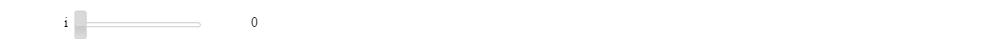

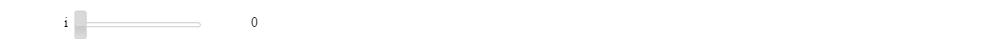

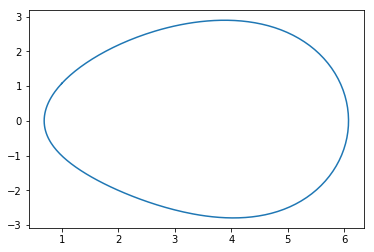

Period:  1
Distance moved :  3.91659663259e-13


<function __main__.UPOplot>

In [229]:
def UPOplot(UPOlist,i):
    r0 = UPOlist[i][1][0]
    tvals = np.linspace(0,2*pi*UPOlist[i][0],300)
    traj = spi.odeint(SnDuff_f,r0,tvals)
    traj = np.transpose(traj)
    plt.plot(traj[0],traj[1])
    plt.show()
    print('Period: ', UPOlist[i][0])
    print('Distance moved : ', dist(UPOlist[i][1][0],UPOlist[i][0]))

interact(UPOplot, UPOlist = fixed(period1),i = (0, len(period1) - 1, 1))

In [221]:
# Combines above UPO lists and saves to file
#saveUPOlist(appendUPOlist(appendUPOlist(period1,period2),period5),'testingUPOs.p')

In [224]:
# Loads saved file
UPOlist = loadUPOlist('testingUPOs.p')

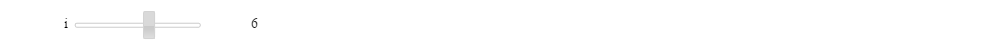

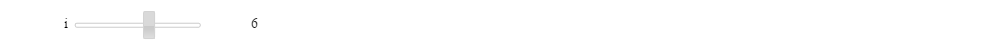

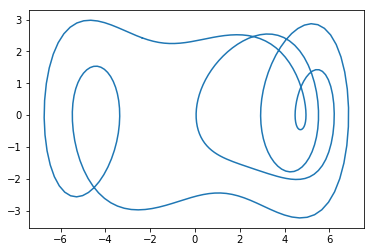

Period:  5
Distance moved :  4.16762640116e-10


In [230]:
interact(UPOplot, UPOlist = fixed(UPOlist),i = (0, len(UPOlist) - 1, 1))

### Development

In [161]:
data = per2
n=2
cluster = True
thres = 1
band = 0.06

cutoff = 10**(-6)
tooclose = 0.01
opttimes = 1

# Apply threshold
under = []
for i in range(len(data)):
    if data[i][5] < thres:
        under.append(data[i])

# Obtaining initial guesses
justpoints = []
for i in range(len(under)):
    justpoints.append(under[i][0:5])
    
if cluster == False: # Taking all points
    guesses = justpoints
else: # Taking point in cluster that moves the least
    guesses = []
    ms = MeanShift(bandwidth=band, bin_seeding=True)
    ms.fit(justpoints)
    labels = ms.labels_
    labels_unique = np.unique(labels)
    for k in labels_unique:
        tmp = []
        for i in range(len(under)):
            if labels[i] == k:
                tmp.append(under[i])
        ind = np.argmin(np.transpose(tmp)[5])
        guesses.append(tmp[ind][0:5])
    
            
    


15


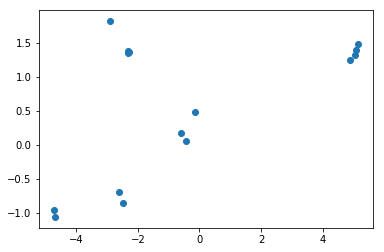

In [162]:
print(len(guesses))
plt.scatter(np.transpose(guesses)[0],np.transpose(guesses)[1])
plt.show()

In [163]:
# Specific distance function
def distn(r0):
    return dist(r0,n)

# Improve guesses
Impg = []
for i in range(len(guesses)):
    tmp = guesses[i]
    # Optimising guesses
    for i in range(opttimes): 
        tmp = minimize(distn,tmp).x
    tmp = tmp.tolist()
    tmp.append(distn(tmp))
    Impg.append(tmp)
    
# Are they good enough?
goodUPOs = []
for i in range(len(Impg)):
    if Impg[i][5] < cutoff:
        goodUPOs.append(Impg[i][0:5])
        
# Is it length n or shorter?
f = factor(n) #List of factors of n (i.e. possible lengths for shorter UPOs)
UPOs = []
for i in f:
    def disttmp(r0):
        return dist(r0,i)
    dellist = [] 
    for j in range(len(goodUPOs)):
        if disttmp(goodUPOs[j]) < cutoff:
            dellist.append[j]
    for j in dellist:
        UPOs.append([i,goodUPOs[j]])
        del goodUPOS[j]
for i in range(len(goodUPOs)):
    UPOs.append([n,goodUPOs[i]])

#Current structure:
#UPOs = [[n1,[r1[0],...,r1[4]]],
#             ...        
#        [nm,[rm[0],...,rm[4]]]]
    



In [164]:
# Are there two in the same place?
closelist = [] # List of indice pairs [i,j] such that the ith and ith UPOs are too close 
for i in range(len(UPOs)):
    if i < len(UPOs) - 1:
        for j in range(i+1,len(UPOs),1):
            diff = np.array(UPOs[i][1]) - np.array(UPOs[j][1])
            if np.dot(diff,diff) < tooclose and UPOs[i][0] == UPOs[j][0]:
                closelist.append([i,j]) 
mergedlist = [] # List of all indices grouped together if their corresponding data points are too close               
for i1 in range(len(UPOs)):
    added = 0
    related = [] # List of indices related to i1
    for j1 in range(len(closelist)): 
        for j2 in range(len(closelist[j1])):
            if closelist[j1][j2] == i1:
                j3 = (j2 + 1)%2
                related.append(closelist[j1][j3]) 
    for i2 in range(len(mergedlist)):
        for i3 in range(len(mergedlist[i2])):
            for i4 in range(len(related)):
                if related[i4] == mergedlist[i2][i3] and added == 0:
                    mergedlist[i2].append(i1)
                    added = 1
    if added == 0:
        mergedlist.append([i1])
    print(mergedlist)
UPOstmp = [] 
for i in range(len(mergedlist)): # Choosing best point of all groups of similar UPOs
    minind = mergedlist[i][0]
    for j in range(1,len(mergedlist[i])):   
        if dist(UPOs[mergedlist[i][j]][1],UPOs[mergedlist[i][j]][0]) < dist(UPOs[minind][1],UPOs[minind][0]):
            minind = mergedlist[i][j]
    UPOstmp.append(UPOs[minind])
UPOs = UPOstmp           

[[0]]
[[0], [1]]
[[0], [1], [2]]
[[0], [1], [2], [3]]
[[0], [1], [2], [3], [4]]
[[0], [1, 5], [2], [3], [4]]
[[0], [1, 5], [2], [3], [4], [6]]
[[0], [1, 5], [2], [3], [4], [6, 7]]
[[0], [1, 5], [2], [3], [4], [6, 7], [8]]
[[0], [1, 5, 9], [2], [3], [4], [6, 7], [8]]
[[0], [1, 5, 9], [2, 10], [3], [4], [6, 7], [8]]
[[0], [1, 5, 9, 11], [2, 10], [3], [4], [6, 7], [8]]
[[0], [1, 5, 9, 11], [2, 10], [3], [4, 12], [6, 7], [8]]
[[0], [1, 5, 9, 11], [2, 10], [3, 13], [4, 12], [6, 7], [8]]
[[0, 14], [1, 5, 9, 11], [2, 10], [3, 13], [4, 12], [6, 7], [8]]


In [165]:
len(UPOs)

7

In [166]:
# Linking Trajectories
UPOstmp = []
for i in range(len(UPOs)):
    orbit = SnDuffPLst(UPOs[i][1],UPOs[i][0] - 1) # full orbit 
    orbitlist = [] # converted to list 
    for j in range(len(orbit)):
        orbitlist.append(np.array(orbit[j]).tolist())
    UPOstmp.append([UPOs[i][0],orbitlist])
UPOs = UPOstmp

def closecheckmUPO(UPOs):
    closelist = [] # List of indice pairs [i,j] such that the ith and ith UPOs are too close 
    for i in range(len(UPOs)):
        if i < len(UPOs) - 1:
            for j in range(i+1,len(UPOs),1):
                diff = np.array(UPOs[i][1]) - np.array(UPOs[j][1])
                if UPOs[i][0] == UPOs[j][0]:
                    same = 0
                    for k1 in range(len(UPOs[i][1])):
                        for k2  in range(len(UPOs[j][1])):
                            diff = np.array(UPOs[i][1][k1]) - np.array(UPOs[j][1][k2])
                            if np.dot(diff,diff) < tooclose:
                                same = 1
                    if same == 1:             
                        closelist.append([i,j]) 
    mergedlist = [] # List of all indices grouped together if their corresponding data points are too close               
    for i1 in range(len(UPOs)):
        added = 0
        related = [] # List of indices related to i1
        for j1 in range(len(closelist)): 
            for j2 in range(len(closelist[j1])):
                if closelist[j1][j2] == i1:
                    j3 = (j2 + 1)%2
                    related.append(closelist[j1][j3]) 
        for i2 in range(len(mergedlist)):
            for i3 in range(len(mergedlist[i2])):
                for i4 in range(len(related)):
                    if related[i4] == mergedlist[i2][i3] and added == 0:
                        mergedlist[i2].append(i1)
                        added = 1
        if added == 0:
            mergedlist.append([i1])
    UPOstmp = [] 
    for i in range(len(mergedlist)): # Choosing best point of all groups of similar UPOs
        minind = mergedlist[i][0]
        for j in range(1,len(mergedlist[i])):   
            if dist(UPOs[mergedlist[i][j]][1],UPOs[mergedlist[i][j]][0]) < dist(UPOs[minind][1],UPOs[minind][0]):
                minind = mergedlist[i][j]
        UPOstmp.append(UPOs[minind])
    UPOstmp = [] 
    for i in range(len(mergedlist)): # Choosing best point of all groups of similar UPOs
        minind = mergedlist[i][0]
        for j in range(1,len(mergedlist[i])):   
            if dist(UPOs[mergedlist[i][j]][1][0],UPOs[mergedlist[i][j]][0]) < dist(UPOs[minind][1][0],UPOs[minind][0]):
                minind = mergedlist[i][j]
        UPOstmp.append(UPOs[minind])
    return UPOstmp   
UPOs = closecheck(UPOs)


[[0]]
[[0], [1]]
[[0, 2], [1]]
[[0, 2], [1], [3]]
[[0, 2], [1], [3, 4]]
[[0, 2], [1], [3, 4], [5]]
[[0, 2], [1, 6], [3, 4], [5]]
